# k-Nearest Neighbors (k-NN) Classification on Breast Cancer Dataset

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

sns.set(style="whitegrid")


## Load Breast Cancer Dataset

In [2]:

cancer = datasets.load_breast_cancer()
X = pd.DataFrame(cancer.data, columns=cancer.feature_names)
y = pd.Series(cancer.target)

print("Dataset shape:", X.shape)
print("Classes:", cancer.target_names)
print("Class distribution:", y.value_counts())


Dataset shape: (569, 30)
Classes: ['malignant' 'benign']
Class distribution: 1    357
0    212
Name: count, dtype: int64


## Exploratory Data Analysis

/tmp/ipykernel_10269/228480837.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette="Set2")


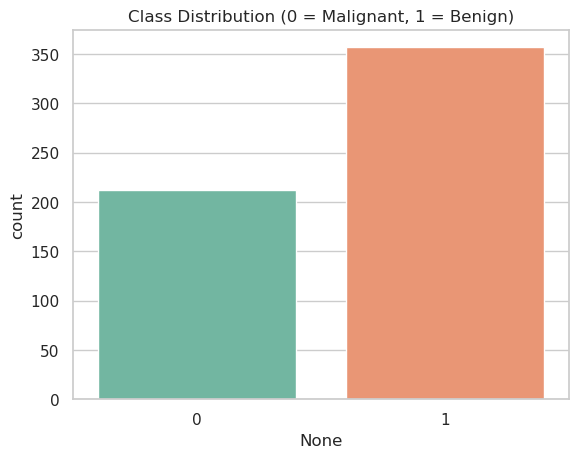

In [3]:

sns.countplot(x=y, palette="Set2")
plt.title("Class Distribution (0 = Malignant, 1 = Benign)")
plt.show()


## Train-Test Split and Scaling

In [4]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Train k-NN Classifier with Different k Values

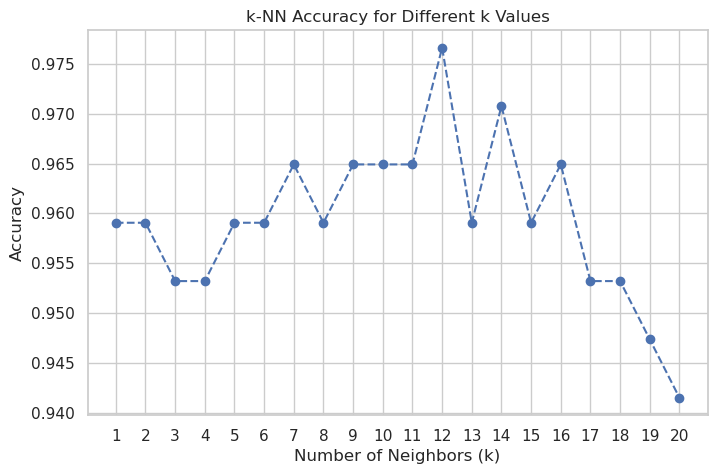

In [5]:

k_values = range(1, 21)
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    accuracies.append(knn.score(X_test_scaled, y_test))

plt.figure(figsize=(8,5))
plt.plot(k_values, accuracies, marker="o", linestyle="--", color="b")
plt.title("k-NN Accuracy for Different k Values")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.xticks(k_values)
plt.show()


## Evaluate Best k

Best k: 12 with accuracy: 0.9766081871345029
Classification Report:
               precision    recall  f1-score   support

   malignant       1.00      0.94      0.97        64
      benign       0.96      1.00      0.98       107

    accuracy                           0.98       171
   macro avg       0.98      0.97      0.97       171
weighted avg       0.98      0.98      0.98       171



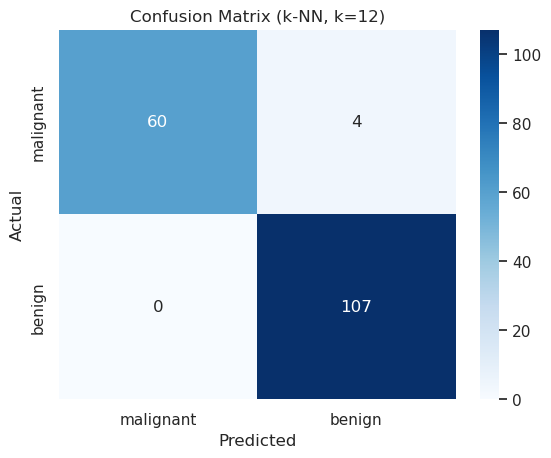

In [6]:

best_k = k_values[np.argmax(accuracies)]
print("Best k:", best_k, "with accuracy:", max(accuracies))

knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train_scaled, y_train)

y_pred = knn_best.predict(X_test_scaled)
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=cancer.target_names))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=cancer.target_names, yticklabels=cancer.target_names)
plt.title(f"Confusion Matrix (k-NN, k={best_k})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## ROC Curve & AUC

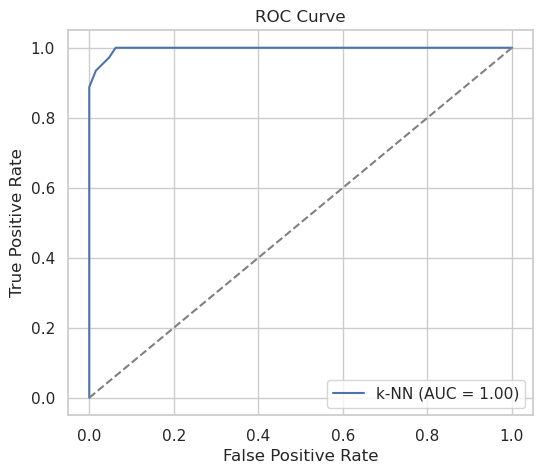

In [7]:

y_prob = knn_best.predict_proba(X_test_scaled)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"k-NN (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


# Precision-Recall Curve

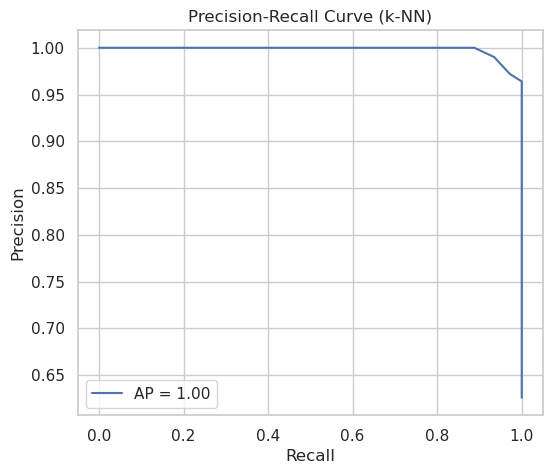

In [10]:
# 📌 Precision-Recall Curve for k-NN
from sklearn.metrics import precision_recall_curve, average_precision_score

y_prob = knn_best.predict_proba(X_test_scaled)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"AP = {ap:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (k-NN)")
plt.legend()
plt.show()


# F1 Score vs Threshold

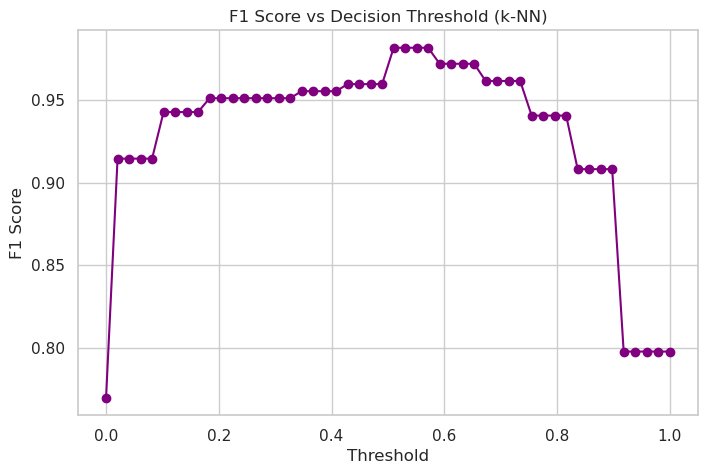

In [11]:
# 📌 F1 Score vs Decision Threshold for k-NN
from sklearn.metrics import f1_score

thresholds = np.linspace(0, 1, 50)
f1_scores = []

for t in thresholds:
    preds = (y_prob >= t).astype(int)
    f1_scores.append(f1_score(y_test, preds))

plt.figure(figsize=(8,5))
plt.plot(thresholds, f1_scores, marker="o", color="purple")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Decision Threshold (k-NN)")
plt.show()


# Cross-Validation Accuracy

In [15]:
# 📌 Cross-Validation Performance
from sklearn.model_selection import cross_val_score

scores = cross_val_score(KNeighborsClassifier(), X, y, cv=5, scoring="accuracy")
print("Cross-Validation Accuracies:", scores)
print("Mean Accuracy:", scores.mean())


Cross-Validation Accuracies: [0.88596491 0.93859649 0.93859649 0.94736842 0.92920354]
Mean Accuracy: 0.9279459711224964


## Actual vs Predicted (Subset Line Plot)

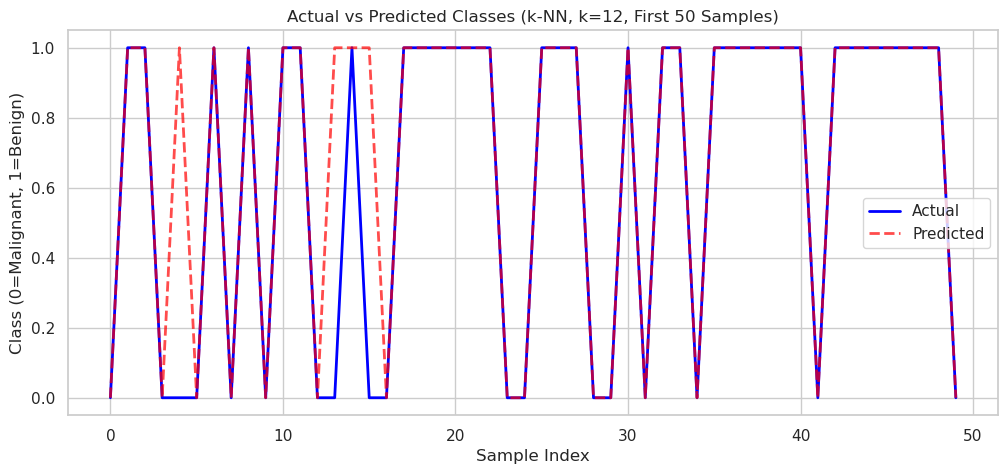

In [13]:

comparison = pd.DataFrame({"Actual": y_test.values, "Predicted": y_pred}).reset_index(drop=True)
subset = comparison.iloc[:50]

plt.figure(figsize=(12,5))
plt.plot(subset.index, subset["Actual"], label="Actual", color="blue", linewidth=2)
plt.plot(subset.index, subset["Predicted"], label="Predicted", color="red", linestyle="--", linewidth=2, alpha=0.7)
plt.title(f"Actual vs Predicted Classes (k-NN, k={best_k}, First 50 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Class (0=Malignant, 1=Benign)")
plt.legend()
plt.show()


# Calibration Curve

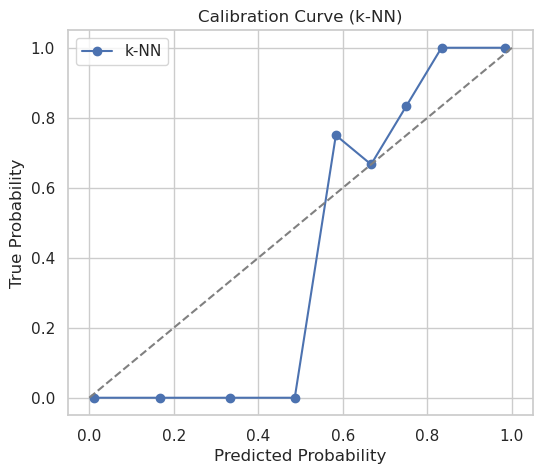

In [14]:
# 📌 Calibration Curve for k-NN
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)

plt.figure(figsize=(6,5))
plt.plot(prob_pred, prob_true, marker="o", label="k-NN")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Calibration Curve (k-NN)")
plt.legend()
plt.show()
